## Pretrain neural network with parameters which had best results in tests and save it

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pycuda.autoinit
import tensorflow as tf

In [2]:
from Modules.Neural_Network import *

### Parameters

In [4]:
#Split an Scale parameters
df_target='dryShrinkage'
test_size=0.2
norm='standard' # 'minmax'

# Model creation parameters
inputs = 84 # df.shape[1]
# hidden_sizes = [64,32,16]   #Original
hidden_sizes = [256,128,64,32,16]
outputs = 1
activ = 'relu'

# Model fit parameters
EPOCHS = 5
loss = 'mse'
optimizer = tf.keras.optimizers.Adam

lr = 0.001
# Delete unnecessary metrics
metrics = ['mae', 'mse', 'mape']
with_predictions = False

# Model Saving parameters
save_model = True
# Saved model format
path='./models/RegModel'
#path='./HDF5Models/Adam4_model.h5'


# Model stats saving parameters
csv_path='./logs/'
save_to_csv=True

parameters=(df_features, df_target, test_size, norm, inputs, hidden_sizes, outputs, activ, EPOCHS, loss, optimizer, lr, metrics, with_predictions, save_model, path)

## Starting the neural network

In [5]:
%%time
model, history, train, test, model_name = create_compile_and_fit(*parameters)

Train set size: (438728, 84) / Train sets target size: (438728,)
Test set size: (109683, 84) / Test sets target size: (109683,) 

Scaling done. Next is model creation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               21760     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)     

## Testing pretrained neural network with real data

In [3]:
from Modules.feature_matrix import featureMatrix
from Modules.full_feature_matrix import create_full_feature_and_target_matrix
from Modules.Neural_Network import *
from timeit import default_timer as timer
from tensorflow.keras import models,layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
X, Y = create_full_feature_and_target_matrix(printProgress=True)

In [5]:
# Combine X and Y dataframes into one 
df_features = pd.concat([X,Y], axis=1)

# Drop thickness and traindevtest columns 
df_features = df_features.drop(columns=["m_dThickness","traindevtest"])

# Drop filenames in an elegant style
filenames = pd.concat([df_features.pop(x) for x in ['peelFile', 'dryFile']], axis=1)
df_features.head(5)

,m_uWidth,m_uLength,B1MoistureAvg,B1TemperatureAvg,B1DensityAvg,B1KnotWidthSum,B1KnotCount,B1DecayWidthSum,B1DecayCount,B1AllOtherDefectWidthSum,...,B9DensityAvg,B9KnotWidthSum,B9KnotCount,B9DecayWidthSum,B9DecayCount,B9AllOtherDefectWidthSum,B9AllOtherDefectCount,dryMoisturePercentage,dryWidth,dryShrinkage
0,1750.23265,1599.76152,113.903722,33.013574,997.511787,125.39330,11,26.9537,2,0.0000,...,1028.177020,157.62055,19,39.25865,2,16.99255,2,8.063503,1633.089727,0.933070
1,1750.23265,1599.18000,100.958000,34.138437,960.649786,0.00000,0,0.0000,0,21.0942,...,956.783924,12.89090,1,0.00000,0,7.03140,1,1.762412,1609.685322,0.919698
2,1750.23265,1601.50608,87.856679,35.469453,826.694515,21.68015,2,0.0000,0,0.0000,...,831.718097,49.21980,3,0.00000,0,16.40660,4,0.619572,1614.120061,0.922232
3,1750.23265,1600.34304,119.887972,35.878984,946.037900,22.26610,3,0.0000,0,0.0000,...,962.829528,15.82065,3,0.00000,0,450.00960,1,0.682885,1620.398997,0.925819
4,1750.23265,1600.92456,87.329798,36.486844,848.591452,35.15700,5,0.0000,0,0.0000,...,849.948758,40.43055,5,0.00000,0,0.00000,0,0.649544,1601.162675,0.914828


In [9]:
df_features.shape

(137, 86)

### Divide it into features and targets + split it to train and test sets

In [6]:
from sklearn.model_selection import train_test_split
# Drop dryShrinkage and dryWidth from features 
# Set dryShrinkage as the target
# Split ratio is 70/30
train_data,test_data,train_targets,test_targets = train_test_split(df_features.drop(["dryShrinkage","dryWidth"],axis=1)
                                                                   ,df_features["dryShrinkage"],test_size=0.3,random_state=42)

In [7]:
print(train_data.shape)
print(test_data.shape)

(95, 84)
(42, 84)


### Standardize / normalize 

In [8]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
transformed_train_data = ss.fit_transform(train_data)
transformed_test_data = ss.transform(test_data)

### Load pre-trained model

In [9]:
# Define model and it's path
model= 'RegModel' # Newest and the best model atm
path = '/home/jovyan/work/team-network-training/Sprint 6/models/'


# Have to define custom_obejcts (functions from Neural_Network.py) also
loaded_model = tf.keras.models.load_model(path+model)       
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               21760     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 65,537
Trainable params: 65,537
Non-trainable params: 0
____________________________________________________

### Evaluate model

In [10]:
model = loaded_model

In [11]:
results = model.evaluate(transformed_test_data, test_targets)

2/2 [==============================] - 1s 5ms/step - loss: 2.7311e-06 - mae: 0.0015 - mse: 2.7311e-06 - mape: 0.1595


### Make predictions with test_data

In [12]:
pred = model.predict(transformed_test_data)

### Visualize results

In [13]:
from Modules.model_accuracy import *


		Predicitons and targets
--------------------------------------------------------
 Average difference:	0.0014207741188957798
 Max difference:	0.004685049876191338
 Min difference:	-0.0009944575545680623
--------------------------------------------------------


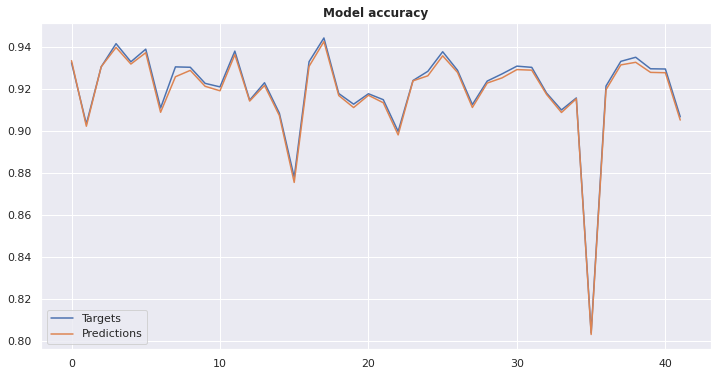

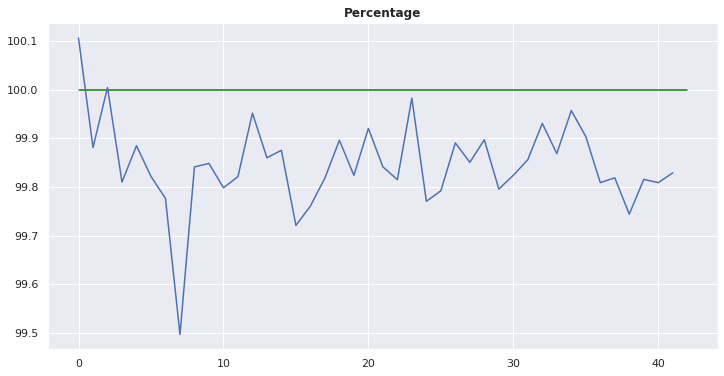

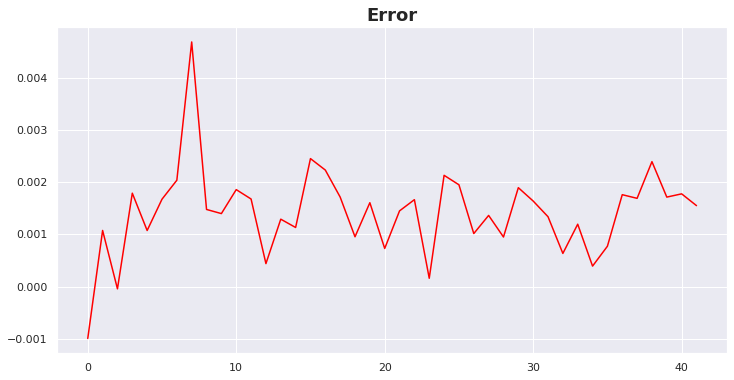

In [14]:
modelAccuracy(model, data=(transformed_test_data,test_targets), visualize=True)

## With bigger test data

In [15]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_targets,test_targets = train_test_split(df_features.drop(["dryShrinkage","dryWidth"],axis=1)
                                                                   ,df_features["dryShrinkage"],test_size=0.99,random_state=42)

In [16]:
bigger_test_data = ss.transform(test_data)

In [17]:
bigger_test_data.shape

(136, 84)

In [18]:
pred = model.predict(bigger_test_data)


		Predicitons and targets
--------------------------------------------------------
 Average difference:	0.0015118660299948234
 Max difference:	0.0056250674898477016
 Min difference:	-0.0009944575545680623
--------------------------------------------------------


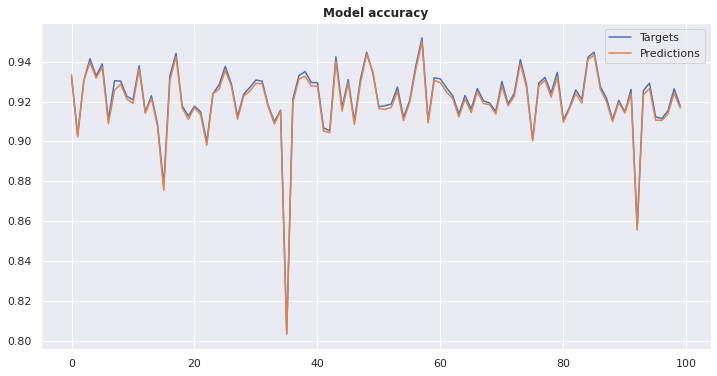

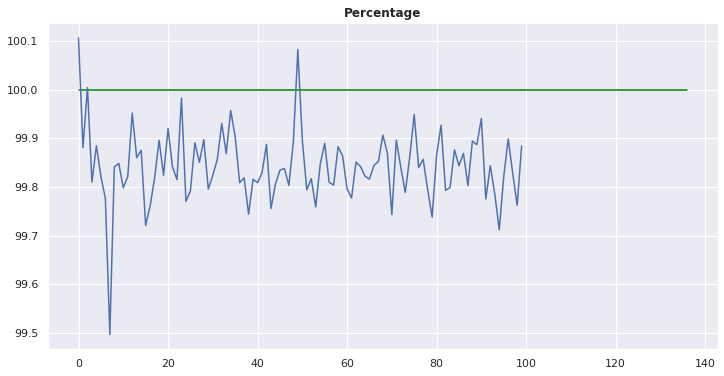

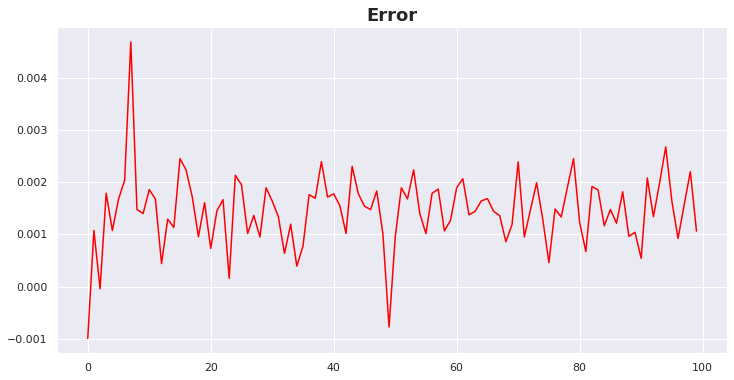

In [19]:
modelAccuracy(model, data=(bigger_test_data,test_targets), visualize=True)